<a href="https://colab.research.google.com/github/Karlamch/karlaMCH/blob/main/ei_u3_04_%3C22150453%3E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar dataframe

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Obtener datos de acciones
df = yf.download(
    tickers='AAPL',            # tickers: AAPL: Apple, TSLA: Tesla, etc.
    start='2024-04-10',        # Fecha de inicio
    end='2025-04-08',          # Fecha de fin
    interval='1d',             # Intervalo de tiempo (1 día)
    group_by=None,             # Agrupar por ticker
    auto_adjust=False,         # ajusta automáticamente los precios de cierre, apertura, máximo y mínimo para tener en cuenta los dividendos y divisiones de acciones.
    actions=False,             # Si se establece en True, incluye datos sobre acciones, como dividendos y divisiones.
    )

# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener

# Paso 1: Mover 'Date' del índice a columna regular
df = df.reset_index()

# Paso 2: Aplanar el MultiIndex de las columnas, manteniendo 'Open', 'High', etc.
df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df.columns.values]


# Paso 3:
#######################################################
## En caso de que no se requiera la hora
# Convertir la columna 'Date' a tipo datetime si no lo es ya
df['Date'] = pd.to_datetime(df['Date'])

df['Date'] = df['Date'].dt.date
##
#######################################################

# Paso 4: La fecha vuelve a ser un índice
df.set_index('Date', inplace=True)


df

[*********************100%***********************]  1 of 1 completed


,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume
Date,,,,,,
2024-04-10,168.800003,169.089996,167.110001,167.779999,166.772797,49709300
2024-04-11,168.339996,175.460007,168.160004,175.039993,173.989212,91070300
2024-04-12,174.259995,178.360001,174.210007,176.550003,175.490158,101593300
2024-04-15,175.360001,176.630005,172.500000,172.690002,171.653305,73531800
2024-04-16,171.750000,173.759995,168.270004,169.380005,168.363190,73711200
...,...,...,...,...,...,...
2025-04-01,219.809998,223.679993,218.899994,223.190002,222.897705,36412700
2025-04-02,221.320007,225.190002,221.020004,223.889999,223.596786,35905900
2025-04-03,205.539993,207.490005,201.250000,203.190002,202.923904,103419000


MEDIAS MOVILES

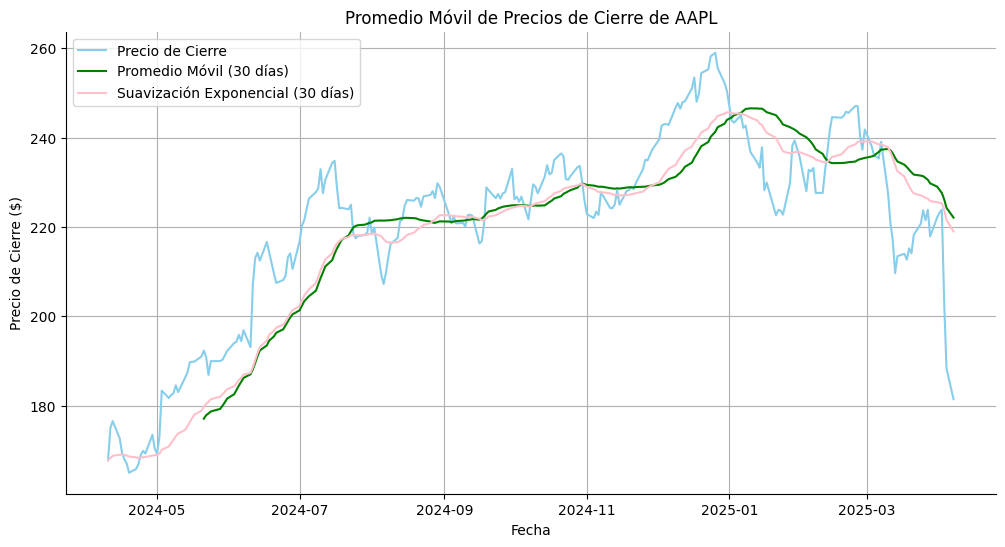

In [4]:
# Promedio Móvil Simple
ventana_sma = 30
df['SMA'] = df['AAPL_Close'].rolling(window=ventana_sma).mean()

# Promedio Móvil Exponencial
ventana_ses = 30
df['SES'] = df['AAPL_Close'].ewm(span=ventana_ses, adjust=False).mean()

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['AAPL_Close'], label='Precio de Cierre', color='skyblue')
plt.plot(df['SMA'], label=f'Promedio Móvil ({ventana_sma} días)', color='green') #los colores con html se le agrega un gato
plt.plot(df['SES'], label=f'Suavización Exponencial ({ventana_ses} días)', color='pink')
plt.title('Promedio Móvil de Precios de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.grid()
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Interpretación.

El promedio móvil de 30 días suaviza el precio, mostrando su dirección general. Cruces hacia arriba sugieren alzas, y hacia abajo, bajas. La suavización exponencial es parecida, pero da más peso a los precios recientes, reaccionando más rápido. Juntas, estas líneas ayudan a ver la volatilidad diaria, la tendencia a corto plazo y posibles cambios cuando el precio cruza los promedios. Recuerda que son herramientas de análisis y necesitan otras confirmaciones para invertir.

# Prueba Dickey-Fuller Aumentada

In [5]:
#Prueba de estacionariedad: Prueba de Dickey-Fuller aumentada (ADF)

#Hipótesis nula (H₀): La serie tiene una raíz unitaria (no es estacionaria).
#Hipótesis alternativa (H₁): La serie es estacionaria.

from statsmodels.tsa.stattools import adfuller

nivel_de_significancia = 0.05

# Realizar la prueba de Dickey-Fuller en los la tendencia
adf_test = adfuller(df['AAPL_Close'].dropna()) # Realiza la prueba ADF


# Interpretación de la prueba ADF
print('Estadístico ADF:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] <= nivel_de_significancia:
    print("La tendencia es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La tendencia no es estacionaria (aceptamos la hipótesis nula).")
#Para deterctar estacionalidad

Estadístico ADF: -1.7739528573286973
p-value: 0.39346788381035025
La tendencia no es estacionaria (aceptamos la hipótesis nula).


# Regresión polinomial


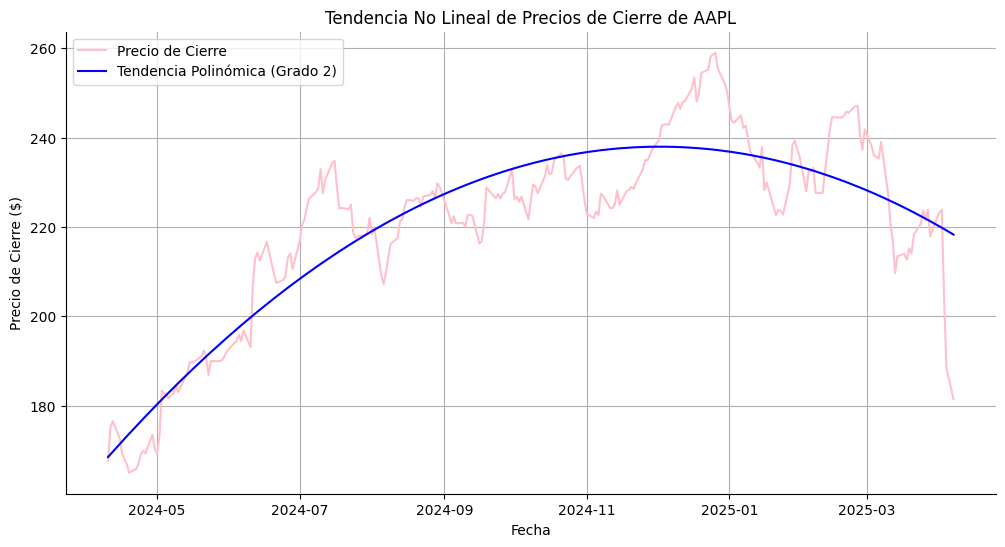

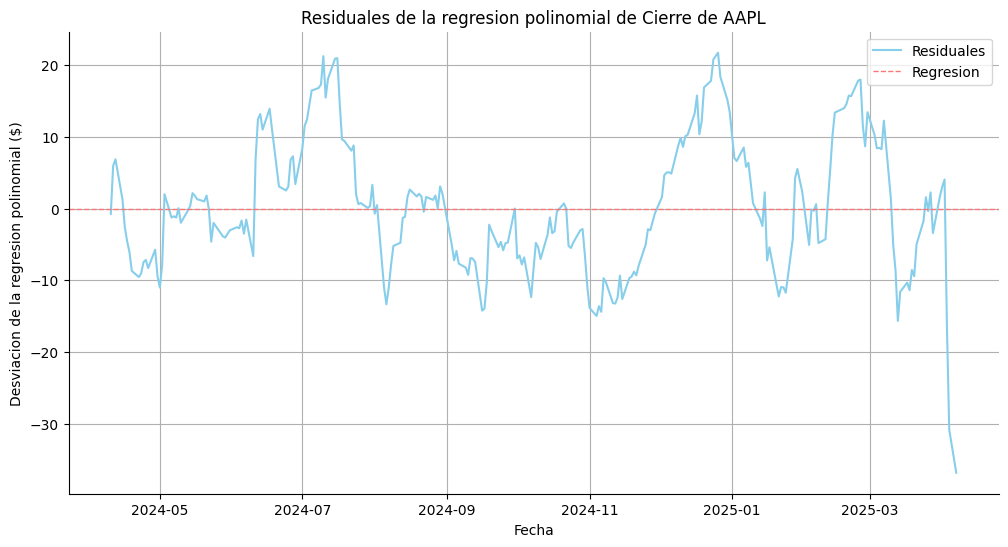

In [6]:
from numpy.polynomial.polynomial import Polynomial

# Paso 1: Convertir fechas a números
# Creamos una nueva columna llamada 'Date' la cual contiene las fechas en
# segundos desde el 1 de de enero de 1970 (tiempo UNIX)
df['Date'] = pd.to_datetime(df.index).map(pd.Timestamp.timestamp)

# Paso 2: Definir las variables independientes (X) y la variable dependiente (y)
X = df['Date']
y = df['AAPL_Close']

# Paso 3: Ajustar un modelo polinómico
grado = 2
modelo = Polynomial.fit(X, y, deg = grado)
df['Poly_Trend'] = modelo(X)
df['Poly_Resid'] = y - df['Poly_Trend']

# Graficar polinomial
# abre una nueva ventana gráfica
plt.figure(
    figsize=(12, 6) # tamaño (horizontal, vertical)
    )

# qué se va a graficar:
plt.plot(
    y,
    label='Precio de Cierre', # etiqueta que aparecerá en la leyenda
    color='pink'
    )

plt.plot(df['Poly_Trend'], label=f'Tendencia Polinómica (Grado {grado})', color='blue')
plt.title('Tendencia No Lineal de Precios de Cierre de AAPL') # Título
plt.xlabel('Fecha')                                           # nombre del eje x
plt.ylabel('Precio de Cierre ($)')                            # nombre del eje y
plt.legend()                                                  # agrega la leyenda
plt.grid()                                                    # agrega una cuadrícula
plt.gca().spines['top'].set_visible(False)                    # elimina los bordes superiores
plt.gca().spines['right'].set_visible(False)                  # elimina los bordes derechos
plt.show()                                                    # muestra el gráfico (innecesario en colab)




# Graficar los residuales del polinomio
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['Poly_Resid'], label='Residuales', color='skyblue')
plt.axhline(0, color='#FB7777', label='Regresion',linestyle='--', linewidth=1)  # Línea horizontal en el valor cero
plt.title('Residuales de la regresion polinomial de Cierre de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Desviacion de la regresion polinomial ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

#Representar la curva de forma más suave

La primera gráfica modeló la tendencia a largo plazo con una curva polinómica de grado 2, mostrando una subida hasta finales de 2024/principios de 2025 y luego una bajada. Esto suavizó el ruido diario, dando una visión general de la dirección del precio.

La segunda gráfica mostró los errores del modelo (residuales). Estos fluctuaron bastante alrededor de cero, indicando que la tendencia general fue capturada, pero no los cambios diarios oa medio plazo. Los errores grandes señalaron cuándo la predicción se desvió del precio real. Sin un patrón claro en los errores, no hay un sesgo obvio en el modelo, pero las fluctuaciones sugieren que otros factores afectarán el precio de AAPL además de esta tendencia simple.

## Para Pros: Series de Fourier

Las series de Fourier descomponen cualquier cosa como una suma de senos y cosenos. Por esta razón, son una herramienta útil para extraer patrones oscilantes. Este es un tema muy complicado y alejado a todo lo que han manejado, por esta razón no les voy a pedir que lo usen. Aquí lo he simplificado tanto como he podido por si se animan.

In [7]:
# Aquí no le muevan a nada
# Básicamente, lo que se hace este bloque es crear la función
# Transformada_de_Fourier, puesto a que no existe para lo que la quiero usar.

def Transformada_de_Fourier(serie, terminos, un_grafico):
  '''La función acepta los argumentos "serie", la cual debe de ser un array
  en numpy y en pandas de la forma df["my_variable"].values. Por otra parte,
  el parámetro "terminos" es un número natural que indica la cantidad de
  términos que desarrolla la serie. Entre mayor sea el número de términos,
  la serie será más precisa, pero más difícil de interpretar.

  La función tiene como salida una lista con los componentes sinosoidales de serie.
  El último elemento de la lista, es la suma de todos los componentes'''

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  from scipy.fftpack import fft, ifft

  # Supongamos que tienes una serie en df['AAPL_Close']
  # Reemplaza esta línea con tu DataFrame y serie específicos
  n = len(serie)

  # Calcular la transformada de Fourier
  transformada_fourier = fft(serie)

  # Obtener las frecuencias
  frecuencias = np.fft.fftfreq(n)

  # Crear un DataFrame para almacenar la frecuencia y su magnitud
  componentes = pd.DataFrame({
      'frecuencia': frecuencias,
      'magnitud': np.abs(transformada_fourier),
      'longitud_de_onda': 1 / frecuencias
  })

  # Ordenar el dataframe de mayor a menor en términos de magnitud

  componentes = componentes.sort_values(by='magnitud', ascending=False)

  # Seleccionar las frecuencias con mayor magnitud (excluyendo la frecuencia cero)
  top_frecuencias = componentes.loc[componentes['frecuencia'] > 0].nlargest(terminos, 'magnitud')
  top_frecuencias.reset_index(drop=True, inplace=True)
  print("Frecuencias principales:\n", top_frecuencias)

  # Crear el índice de tiempo para la serie
  t = np.arange(n)

  # Graficar cada componente de frecuencia junto con la serie original
  plt.figure(figsize=(12, 4))

  componente_temporal_sumado = np.zeros_like(serie)
  componentes_temporales = []

  n=0
  for i, row in top_frecuencias.iterrows():
      n+=1
      # Copiar la transformada de Fourier y mantener solo la frecuencia actual
      fourier_component = np.zeros_like(transformada_fourier)
      idx = np.where(frecuencias == row['frecuencia'])[0][0]  # índice de la frecuencia en la FFT
      fourier_component[idx] = transformada_fourier[idx]  # mantener solo la frecuencia positiva
      fourier_component[-idx] = transformada_fourier[-idx]  # mantener la frecuencia negativa correspondiente
      if n == (terminos+1):
        break

      # Reconstruir la señal en el tiempo
      componente_temporal = ifft(fourier_component).real
      componentes_temporales.append(componente_temporal)
      componente_temporal_sumado += componente_temporal

      # Graficar la componente
      plt.plot(
          componente_temporal,
          label=f'Longitud de onda {1 / row["frecuencia"]:.0f}',
          alpha=1,
          linewidth = 0.5,
          )
      plt.title('Componentes de Fourier de la Serie')
      plt.xlabel('Tiempo')
      plt.ylabel('Valor')
      plt.legend()
      plt.grid()

  componentes_temporales.append(componente_temporal_sumado)
  plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  if not un_grafico:
    plt.figure(figsize=(12, 4))
    plt.plot(serie, label='Serie Original', color='black', alpha=0.5)
  plt.plot(componente_temporal_sumado, label='Componente temporal sumada', color='#779BFB')
  plt.legend()
  plt.title('Suma de los Componentes de Fourier de la Serie')
  plt.xlabel('Tiempo')
  plt.ylabel('Valor')
  plt.grid()
  plt.show()

  return componentes_temporales

  #Descompone los residuales, y la segunda tabla las suma y las acomoda a su favor

Frecuencias principales:
    frecuencia     magnitud  longitud_de_onda
0    0.008032  6300.728394            124.50
1    0.004016  4123.318601            249.00
2    0.012048  3672.439065             83.00
3    0.020080  2583.720835             49.80
4    0.016064  1941.032569             62.25


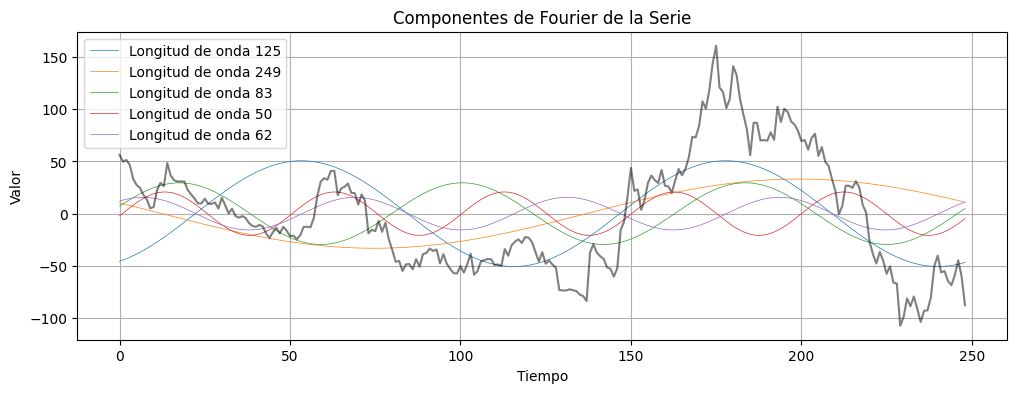

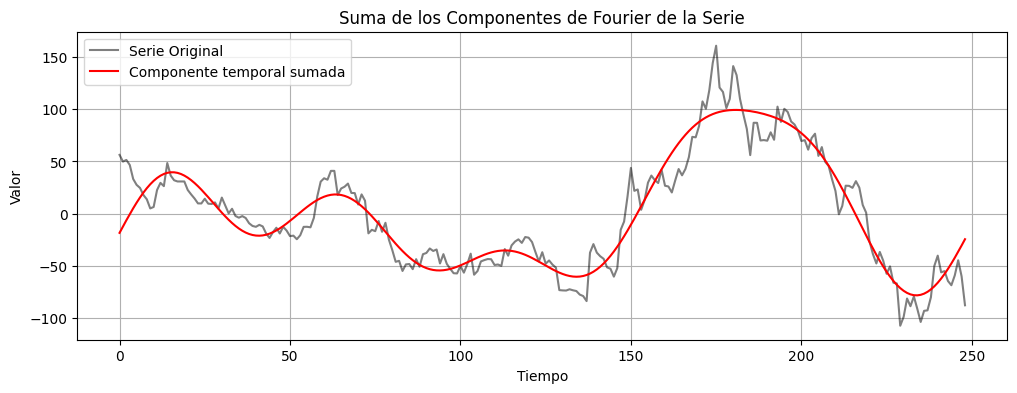

In [ ]:
serie = df['Poly_Resid'].values
terminos = 5
un_grafico = False

cts = Transformada_de_Fourier(serie, terminos, un_grafico)

# cts: componente temporal sumado


En estos gráficos, la longitud de onda equivale a la unidad de tiempo (en este caso, días) que tarda la onda en volver al mismo sitio. Algo que en nuestro contexto podríamos interpretar como estasionalidad. Vemos que la oscilación más grande se presenta cada 378 días. Dado que esto es más de un año, esto sería más bien un ciclo. Sin embargo, se puede apreciar algo muy interesante, la longitud de onda siguiente es de 126 en unidades de tiempo (días) que es justo la mitad de la cantidad de días de negociación en un año!!! 😯

Éste análisis de Fourier revela las principales ondas sinusoidales que componen la serie de tiempo original. La tabla cuantifica la frecuencia, magnitud y longitud de onda de estos componentes, mientras que el gráfico los visualiza, mostrando cómo diferentes ciclos de distintas duraciones contribuyen a las fluctuaciones observadas en la serie original.

Éste gráfico muestra cómo la suma de los principales componentes de Fourier puede aproximar la serie de tiempo original, capturando sus tendencias y ciclos dominantes y suavizando las fluctuaciones de menor importancia. La calidad de la aproximación depende de cuántos y cuáles componentes de Fourier se incluyan en la suma.


# Gráfico de autocorrelación

El gráfico de autocorrelación tiene como eje vertical los valores de la r de Pearson objenidos desplazando la serie hacia atrás en el tiempo. La medida de estos desplazamientos se muestra en el eje horizontal "lags". Se puede ver que de fondo hay una especie de sombra, esa sombra muestra el intervalo de confianza con el nivel de significancia que establezcan. Si la r de Pearson para un lag específico está fuera fuera de esa sombra, hay un nivel de confianza para afirmar que $r\neq0$ y por lo tanto hay correlación.
<br>
Este gráfico se usa para muchas cosas. Nosotros lo intentamos usar para obtener la estacionalidad, pero también se usa para obtener algunos parámetros del modelo ARIMA.

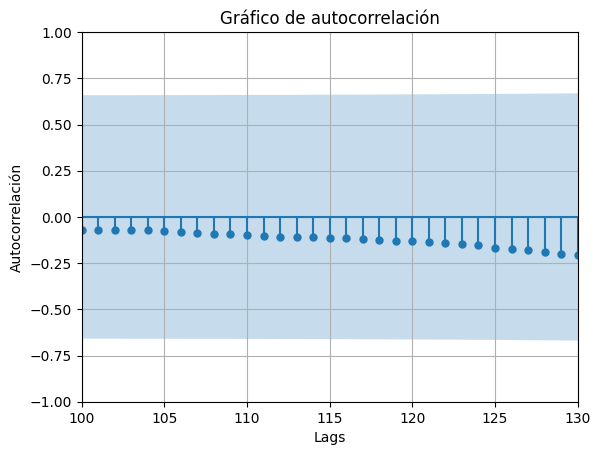

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

nivel_de_significancia = 0.05

plot_acf(
    df['AAPL_Close'],
    lags=130,
    alpha=nivel_de_significancia
    )

plt.xlim([100, 130])
plt.ylim([-1, 1])
plt.title('Gráfico de autocorrelación')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.grid()
plt.show()

# Gráfico de autocorrelación parcial (PACF)

Su propósito principal es ayudar a identificar el orden de dependencia en una serie temporal (útil para ARIMA), es decir, cuántos valores anteriores están correlacionados con el valor actual, después de eliminar el efecto de las observaciones intermedias.

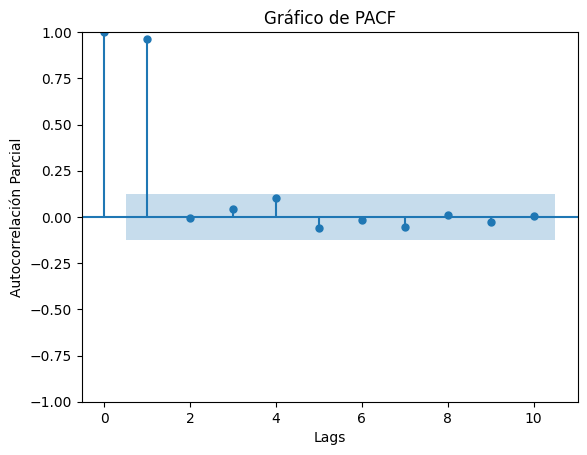

In [10]:
# Generar el gráfico PACF
from statsmodels.graphics.tsaplots import plot_pacf

nivel_de_significancia = 0.05
plot_pacf(df['AAPL_Close'], lags=10, alpha=nivel_de_significancia)
plt.title('Gráfico de PACF')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación Parcial')
plt.show()


 El gráfico de PACF sugiere fuertemente que la serie de tiempo subyacente podría ser modelada adecuadamente utilizando un modelo Autorregresivo de orden 1, donde el valor actual de la serie está directamente influenciado por su valor inmediatamente anterior.

# Descomposición de la serie

`sm.tsa.seasonal_descompose` descompone la serie de tiempo en los componentes Trend, Seasonal y Resid, que son Tendencia, Estacionalidad y Residuos, respectivamente. De tal manera que la serie de tiempo es igual la suma de estos tres elementos.

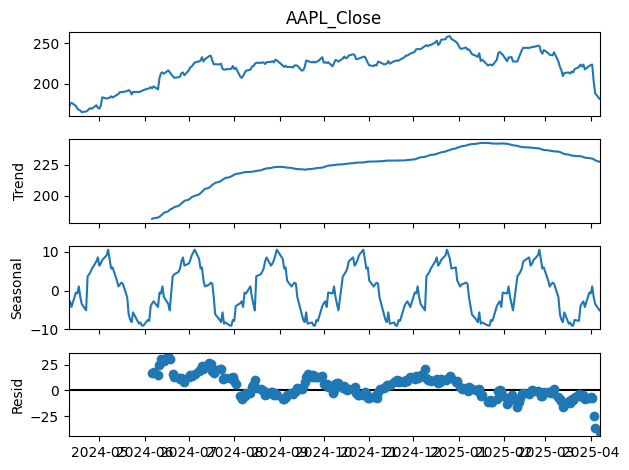

In [9]:
# Descomponer la serie temporal
import statsmodels.api as sm

descomposicion = sm.tsa.seasonal_decompose(
    df['AAPL_Close'],
    model='additive',
    period=40,
    extrapolate_trend=0,
    two_sided=False,
    )  # 252 días de negociación al año
fig = descomposicion.plot()
plt.show()


Ésta descomposición estacional nos ayuda a visualizar cómo la tendencia subyacente, los patrones estacionales recurrentes y los factores residuales contribuyen al comportamiento del precio de cierre de Tesla a lo largo del tiempo. Analizar estos componentes por separado puede proporcionar información valiosa para la previsión y la comprensión de los impulsores del precio.

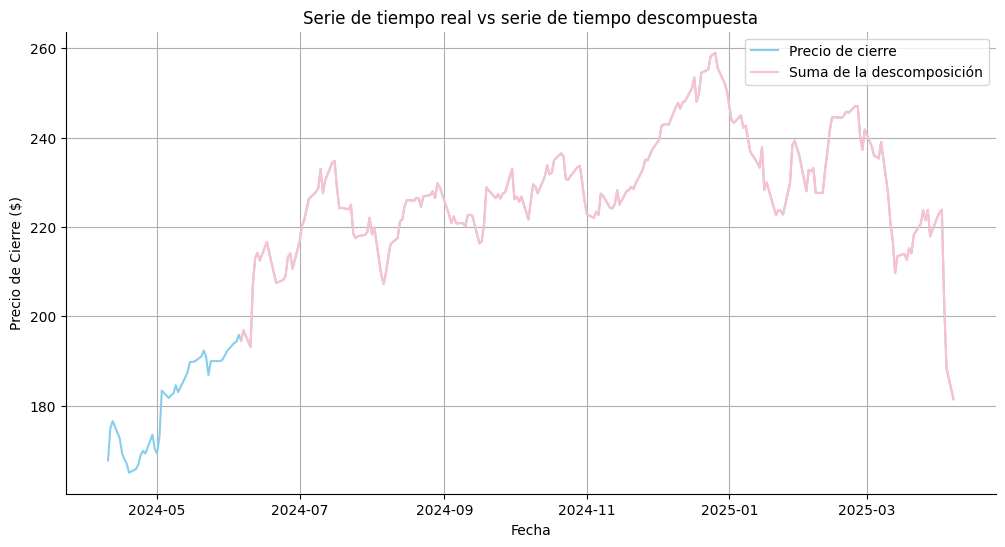

In [12]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['AAPL_Close'], label='Precio de cierre', color='skyblue')
plt.plot(descomposicion.trend + descomposicion.seasonal + descomposicion.resid, label=f'Suma de la descomposición', color='pink')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

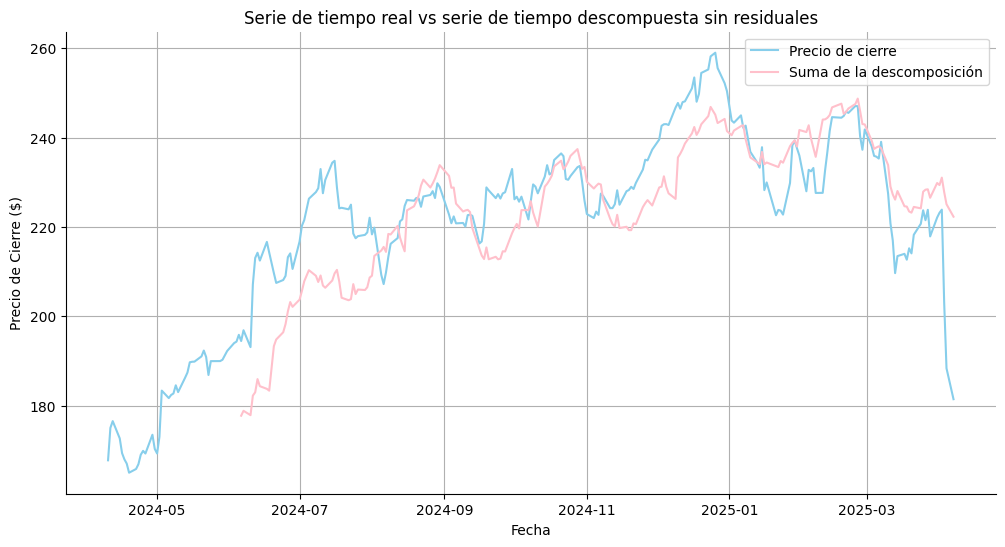

In [11]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['AAPL_Close'], label='Precio de cierre', color='skyblue')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Suma de la descomposición', color="pink")
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Éste gráfico visualiza el impacto de eliminar los residuos de la serie descompuesta. Nos muestra la parte del comportamiento del precio de cierre de AAPL que puede explicarse por la tendencia y la estacionalidad, y las diferencias revelan la magnitud de las fluctuaciones irregulares o no modeladas

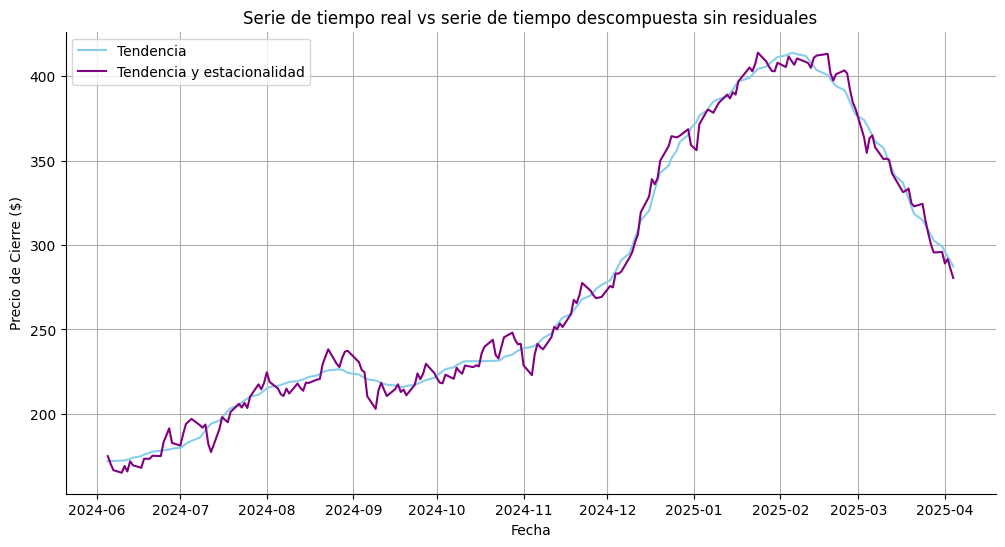

In [ ]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(descomposicion.trend, label='Tendencia', color='skyblue')
plt.plot(descomposicion.trend + descomposicion.seasonal, label=f'Tendencia y estacionalidad', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin residuales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

**Importante**: Es posible que hayan campturado bien la estacionalidad y que la prueba ADF de los residuales les indique que hay estacionariedad. Sin embargo, en el gráfico anterior vemos que no hay mucha diferencia entre la tendencia y la tendencia con estacionalidad. Por lo tanto, la estacionalidad, aunque existe, no es significativa. Esto se ilustra en el siguiente gráfico.

 Podemos observar cómo la línea morada sigue la tendencia general de la línea azul clara, pero con oscilaciones superpuestas que representan el patrón estacional. Estas oscilaciones parecen tener una frecuencia relativamente constante a lo largo del tiempo, lo que es característico de la estacionalidad.
 Éste gráfico destaca la contribución de la componente estacional al comportamiento del precio de cierre de AAPL, mostrando cómo se superpone a la tendencia subyacente para generar las fluctuaciones más a corto plazo que observamos en la serie de tiempo real.

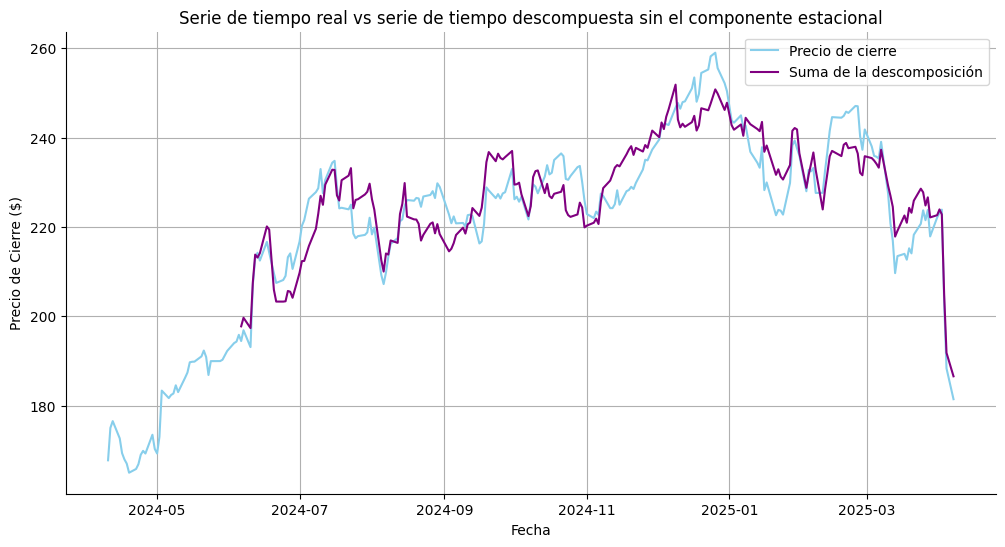

In [13]:
# Graficar descomposición
plt.figure(figsize=(12, 6)) # abre una nueva ventana gráfica
plt.plot(df['AAPL_Close'], label='Precio de cierre', color='skyblue')
plt.plot(descomposicion.trend + descomposicion.resid, label=f'Suma de la descomposición', color='purple')
plt.title('Serie de tiempo real vs serie de tiempo descompuesta sin el componente estacional')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre ($)')
plt.legend()
plt.grid()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

En este gráfico, la línea morada sigue la tendencia general de la línea azul clara, pero las fluctuaciones de alta frecuencia que podrían atribuirse a la estacionalidad se han suavizado.

Podemos observar que en algunos puntos, la línea azul tiene picos más altos o valles más bajos que la línea morada, lo que sugiere la influencia de la estacionalidad en esos momentos.
La diferencia entre las dos líneas varía a lo largo del tiempo, lo que indica que la magnitud de la influencia estacional puede no ser constante.
Nos permite ver cómo se vería la serie de tiempo del precio de cierre de AAPL si se removieran los patrones estacionales. Las diferencias entre la serie real y esta versión desestacionalizada resaltan el impacto de la estacionalidad en las fluctuaciones del precio.

# Prueba Wilcoxon pareada para verificar si la estacionalidad tiene un efecto significativo

In [ ]:
from scipy.stats import wilcoxon

# Prueba Wilcoxon pareada para el efecto significativo de la estacionalidad

#Hipótesis nula (H₀): Ambas series son iguales.
#Hipótesis alternativa (H₁): Ambas series son diferentes

tendencia = descomposicion.trend
tendencia_estacionalidad = descomposicion.seasonal + descomposicion.trend

# Eliminar valores NaN de ambas series
tendencia.dropna(inplace=True)
tendencia_estacionalidad.dropna(inplace=True)

# Realizar la prueba de Wilcoxon
w_stat, p_valor = wilcoxon(tendencia, tendencia_estacionalidad)

print("Estadístico de Wilcoxon:", w_stat)
print("Valor p:", p_valor)
print("\n")

# Interpretación de los resultados
if p_valor < 0.05:
    print("El valor p es menor que 0.05, por lo tanto, rechazamos la hipótesis nula.")
    print("Conclusión: La estacionalidad tiene un efecto significativo en la serie de tiempo.")
else:
    print("El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.")
    print("Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.")


Estadístico de Wilcoxon: 10418.0
Valor p: 0.5264138152571085


El valor p es mayor o igual que 0.05, por lo tanto, no podemos rechazar la hipótesis nula.
Conclusión: La estacionalidad no tiene un efecto significativo en la serie de tiempo.


# Prophet

In [ ]:
# Este data frame son del siguiente año a df. Esto con el propósito de testear prophet
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Obtener datos de acciones
df2 = yf.download(
    tickers='AAPL',            # tickers: AAPL: Apple, TSLA: Tesla, etc.
    start='2018-01-01',        # Fecha de inicio
    end='2018-12-30',          # Fecha de fin
    interval='1d',             # Intervalo de tiempo (1 día)
    group_by=None,             # Agrupar por ticker
    auto_adjust=False,         # ajusta automáticamente los precios de cierre, apertura, máximo y mínimo para tener en cuenta los dividendos y divisiones de acciones.
    actions=False,             # Si se establece en True, incluye datos sobre acciones, como dividendos y divisiones.
    )

# Link para inspeccionar tickers: https://www.nasdaq.com/market-activity/stocks/screener

# Paso 1: Mover 'Date' del índice a columna regular
df2 = df2.reset_index()

# Paso 2: Aplanar el MultiIndex de las columnas, manteniendo 'Open', 'High', etc.
df2.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df2.columns.values]


# Paso 3:
#######################################################
## En caso de que no se requiera la hora
# Convertir la columna 'Date' a tipo datetime si no lo es ya
df2['Date'] = pd.to_datetime(df2['Date'])

df2['Date'] = df2['Date'].dt.date
##
#######################################################

# Paso 4: La fecha vuelve a ser un índice
df2.set_index('Date', inplace=True)


df2

[*********************100%***********************]  1 of 1 completed


,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.426826,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.419788,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.607529,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.069859,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,40.917316,82271200
...,...,...,...,...,...,...
2018-12-21,39.215000,39.540001,37.407501,37.682499,35.905140,382978400
2018-12-24,37.037498,37.887501,36.647499,36.707500,34.976128,148676800
2018-12-26,37.075001,39.307499,36.680000,39.292500,37.439190,234330000


In [ ]:
!pip install prophet

*CONCLUSIÓN*

El precio de cierre de AAPL durante el período analizado está influenciado por una tendencia alcista general, patrones estacionales de menor impacto, una dependencia significativa del precio del día anterior, y también muestra algunas dependencias a largo plazo, además de fluctuaciones irregulares que no se explican fácilmente por estos componentes. Para una predicción precisa, sería necesario construir modelos estadísticos que capturen estas diferentes características de la serie de tiempo.